In [1]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
import os, sys
import warnings
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from scipy import stats
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

In [2]:
orgData_dir = "~/jordan/MDwarf/dataset/catalogs/preMS_cand.csv"
orgData_df = pd.read_csv(orgData_dir)

print(orgData_df.columns, orgData_df.shape)

Index(['obsid', 'designation', 'obsdate', 'lmjd', 'mjd', 'planid', 'spid',
       'fiberid', 'ra_obs', 'dec_obs', 'snru', 'snrg', 'snrr', 'snri', 'snrz',
       'class', 'subclass', 'z', 'z_err', 'magtype', 'ra', 'dec', 'ewha',
       'ewha_err', 'type', 'na', 'id', 'RA_ICRS', 'DE_ICRS', 'rest',
       'b_rest_x', 'B_rest_xa', 'rlen', 'ResFlag', 'ModFlag', 'source_id',
       'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'duplicated_source', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_bp_mean_mag', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag', 'bp_rp',
       'radial_velocity', 'radial_velocity_error', 'rv_nb_transits', 'lum_val',
       'astrometric_chi2_al', 'astrometric_n_good_obs_al'],
      dtype='object') (6788, 59)


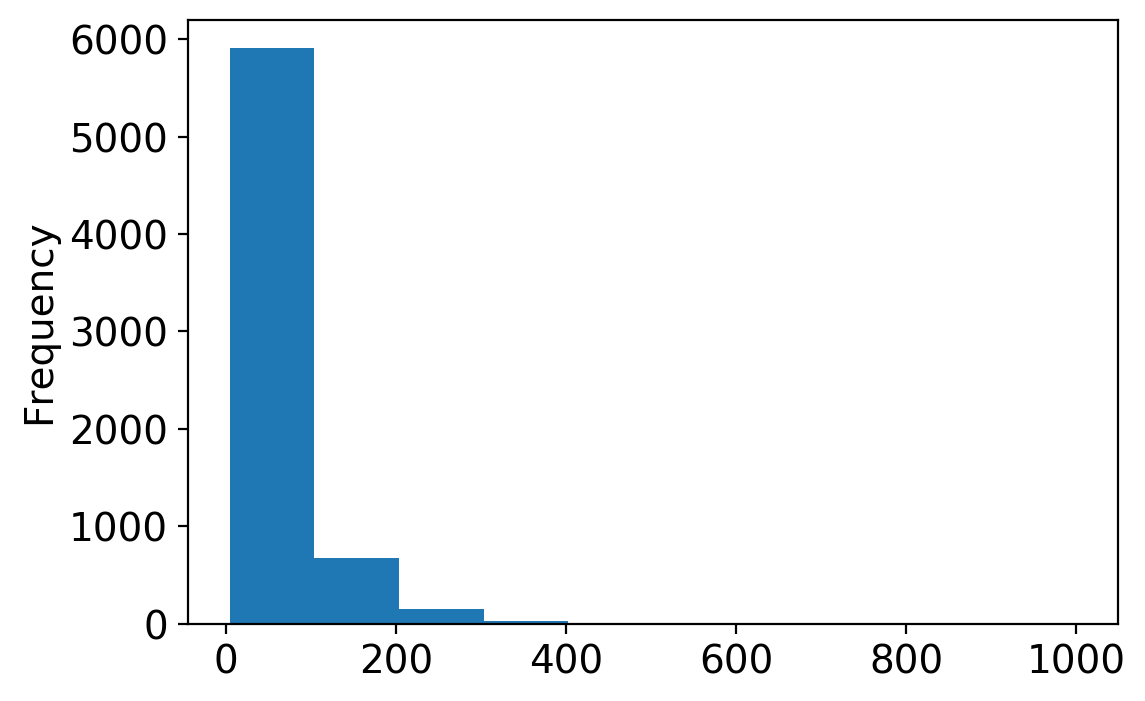

In [100]:
orgData_df['snri'].plot(kind='hist')

In [17]:
lm = LAMOST(dataset=6)
lm.token='AAaHdn8fTr'
preMS_dir = '/share/data/jdli/preMS/'

# lm.downloadFits(orgData_dir.obsid[0], savedir='./dataset/dr6/')
for i,obsid in tqdm(enumerate(orgData_df.obsid)):
    lm.downloadFits(orgData_df.obsid[i], 
                    savedir=preMS_dir)

In [11]:
from laspec.read_spectrum import read_spectrum
from laspec.lamost import lamost_filepath

from laspec.group_specs import groupSpec
from laspec.line_indices import measure_line_index

In [12]:
fp = '/share/data/jdli/preMS/'
GroupSpec = groupSpec(fp)

In [86]:
idx = 500
spec = GroupSpec[idx]

z = 0.00205785
line_info_dib6708 = {'line_center':         6708,
                     'line_range':          (6703, 6713),
                     'line_shoulder_left':  (6690, 6603),
                     'line_shoulder_right': (6713, 6720)}

line_indx = measure_line_index(wave=spec['wave'],
                               flux=spec['flux'],
                               line_info=line_info_dib6708,
                               num_refit=(100, 0),
                               return_type='dict',
                               verbose=True,
                               z=z)

In [59]:
for key in line_indx.keys():
        print(key, line_indx[key])
#         print(np.sum(np.isnan(line_indx.values())))

SN_local_flux_err 95.52141189575195
SN_local_flux_std 22.160684856336577
num_bad_pixel 0
EW_int 1.4566936
EW_int_err 0.23941650776961138
mod_linear_slope -0.1242122591614729
mod_linear_slope_err 0.04179767417377872
mod_linear_intercept 928.798457095412
mod_linear_intercept_err 280.4006010514921
mod_gauss_amplitude 1.6152740695793415
mod_gauss_amplitude_err 0.41961831442685865
mod_gauss_center 6709.011409601031
mod_gauss_center_err 1.705014073104961
mod_gauss_sigma 5.849455194320536
mod_gauss_sigma_err 1.9209189975164604
mod_gauss_amplitude_std nan
mod_gauss_center_std nan
mod_gauss_sigma_std nan


In [66]:
li_indexes = []
for idx in tqdm(range(len(GroupSpec))):
    spec = GroupSpec[idx]
    line_indx = measure_line_index(wave=spec['wave'], 
                                   flux=spec['flux'], 
                                   line_info=line_info_dib6708,
                                   num_refit=(100, 0), return_type='dict', verbose=True, z=z)
    li_indexes += [line_indx['EW_int']]
    
li_indexes = np.array(li_indexes)

 15%|█▍        | 996/6788 [00:29<04:28, 21.57it/s]/home/jdli/jordan/laspec/laspec/line_indices.py:170: RuntimeWarning: invalid value encountered in true_divide
  noise_std = np.std(flux_shoulder / cont_shoulder)
/home/jdli/jordan/laspec/laspec/line_indices.py:172: RuntimeWarning: invalid value encountered in true_divide
  resi_range = 1 - flux_range / cont_range
/home/jdli/anaconda3/envs/py3x/lib/python3.7/site-packages/lmfit/models.py:60: RuntimeWarning: invalid value encountered in greater
  halfmax_vals = np.where(y > (maxy+miny)/2.0)[0]
100%|██████████| 6788/6788 [02:58<00:00, 38.08it/s]


In [74]:
li_indexes = np.array(li_indexes)

len(li_indexes[li_indexes>5])

56

In [98]:
np.argwhere(li_indexes>50)

array([[353]])

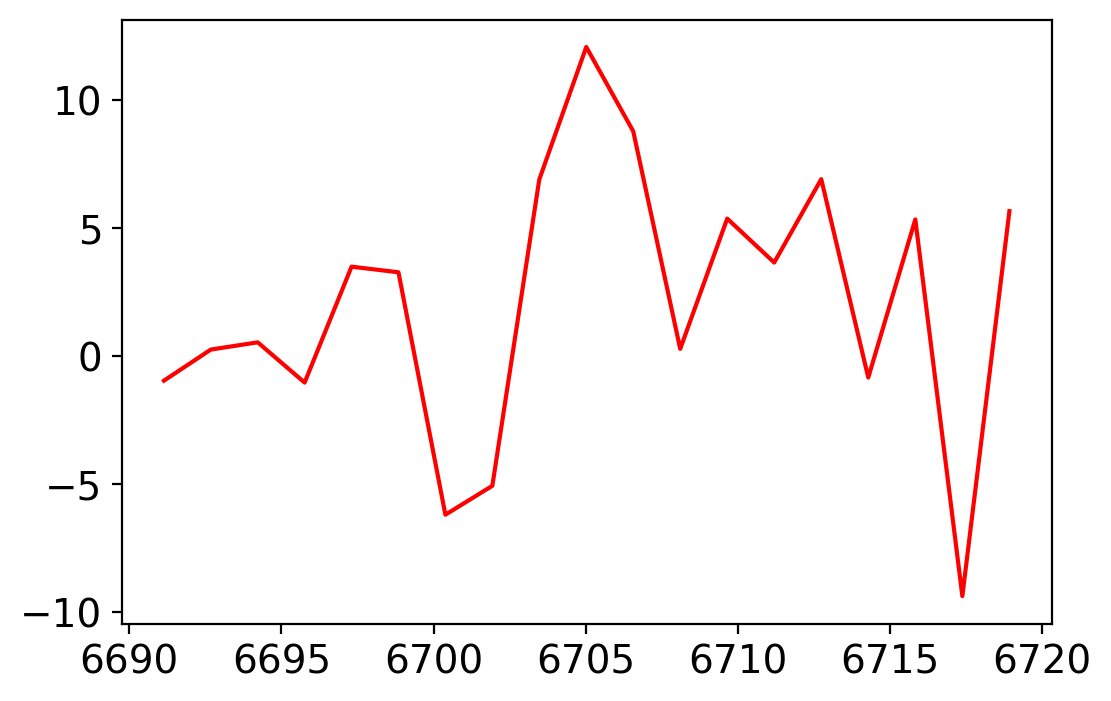

In [99]:
spec = GroupSpec[353]
wave, flux = np.array(spec['wave']), np.array(spec['flux'])
ind_range = (wave > 6690.) & (wave < 6720.)
fig = plt.figure()

plt.plot(wave[ind_range], flux[ind_range], 'r-')
# plt.plot(wave[ind_range], cont_range, 'b-')
# plt.plot(wave[ind_shoulder], flux[ind_shoulder], 'm-')
# plt.title(r'line' + str(line_info['line_center']) + r'of ' + filename)